# **Project-1: Stabilization of a Inverted pendulum on a cart**

Dhinakar Venkatagiri

1229296993


###**Objective Function:**
The primary goal is to design a controller that steers an inverted pendulum on a cart to an upright position and maintains it there. The system starts with the pendulum slightly tilted from the vertical position, and the objective is to find control inputs that drive both the pendulum's angle and the cart's position to zero.



---


###**State Variables:**

*   x[0]: Cart's position.
*   x[1]: Cart's velocity.
*   x[2]:  Pendulum's angle with the vertical
*   x[3]:  Pendulum's angular velocity.

### **Control Variables:**
*   u: Control force applied to the cart.



---
### **System Dynamics:**

The position of the cart (x[0]) and the angle of the pendulum (x[2]) are integrated over time using their respective velocities. Therefore, we have:
\begin{equation}
\dot{x}[0] = x[1]
\end{equation}

\begin{equation}
\dot{x}[2] = x[3]
\end{equation}

These are simple integrative relationships.

The velocity of the cart (x[1]) and the angular velocity of the pendulum (x[3]) are given by the following ODEs, which arise from the force and torque balances:
For the cart:

\begin{equation}
\dot{x}[1] = \frac{u + m \sin(x[2]) (l x[3]^2 + g \cos(x[2]))}{M + m - m \cos^2(x[2])}
\end{equation}

For the pendulum:

\begin{equation}
\dot{x}[3] = \frac{-l m x[3]^2 \sin(x[2]) \cos(x[2]) - \sin(x[2]) u - (M + m) g \sin(x[2])}{l (M + m - m \cos^2(x[2]))}
\end{equation}

So, altogether, we have these four equations capturing the system dynamics, where x[0] is the cart's position, x[1] is the cart's velocity, x[2] is the pendulum's angle, and x[3] is the pendulum's angular velocity.


Where:


- \( g \) is the gravitational acceleration

- \( M \) is the mass of the cart

- \( m \) is the mass of the pendulum
- \( l \) stands for the effective length of the pendulum




In [10]:
import logging
import math
import random
import numpy as np
import time
import torch
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
from IPython.display import Image, display

!pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml')
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

### **Assumptions**

- \( g \) is the gravitational acceleration, with a value of:
$$ g = 9.81 \, \text{m/s}^2 $$

- \( M \) is the mass of the cart, assigned as:
$$ M = 0.5 \, \text{kg} $$

- \( m \) is the mass of the pendulum, defined as:
$$ m = 0.2 \, \text{kg} $$

- \( l \) stands for the effective length of the pendulum, estimated to be:
$$ l = 0.3 \, \text{m} $$

### **Neural Network-based Controller:**

The Controller class implements a feedforward neural network with three layers. This network is designed to generate the control input u based on the current state of the system.

### **Simulation:**

The Simulation class is used to simulate the system for a specified number of time steps. In each time step, the controller's output is used as input to the system dynamics to get the new state.

### **Training:**

The Optimize class is used to train the neural network controller. The goal is to minimize the mean squared error between the final state of the simulation and a target state, which is [0., 0., 0., 0.] indicating upright pendulum with the cart at the origin and not moving.

[1] loss: 1.994


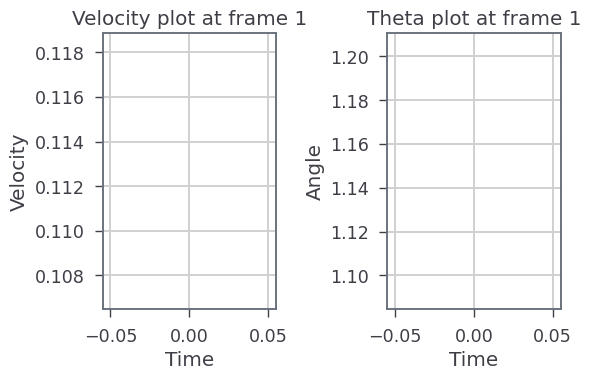

[2] loss: 1.477


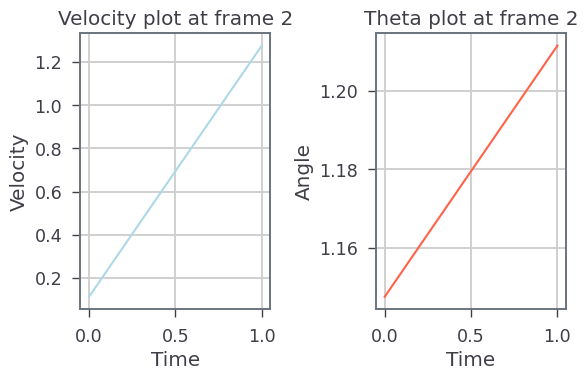

[3] loss: 1.301


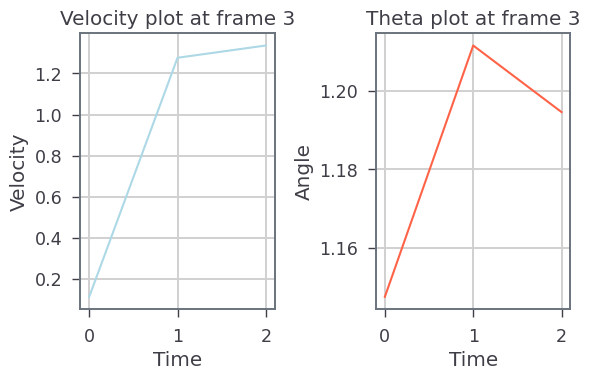

[4] loss: 1.057


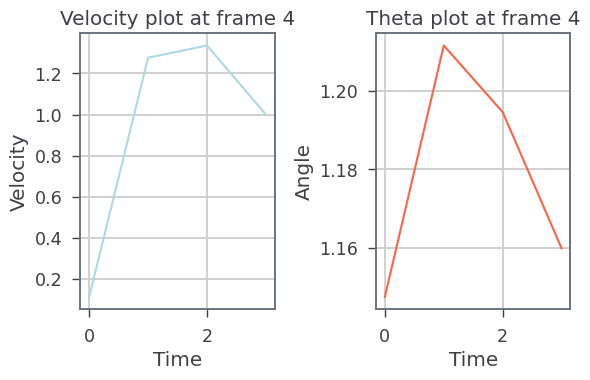

[5] loss: 0.909


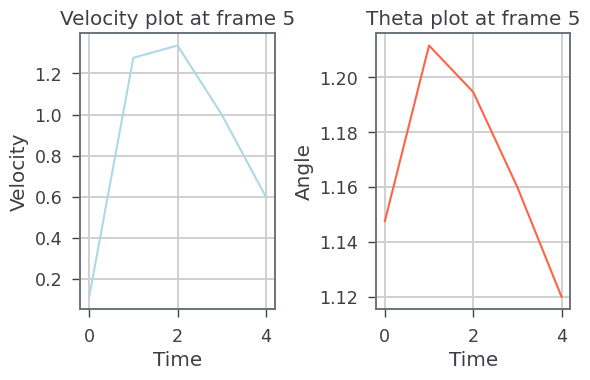

[6] loss: 0.798


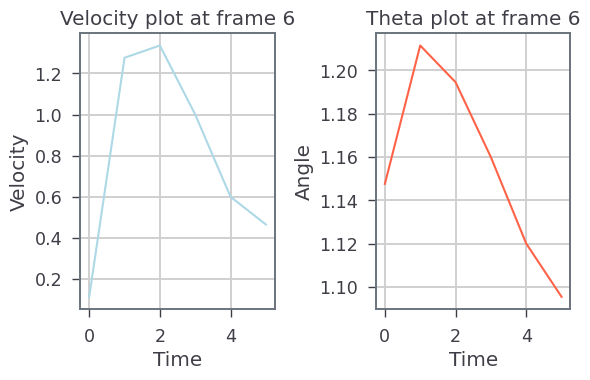

[7] loss: 0.671


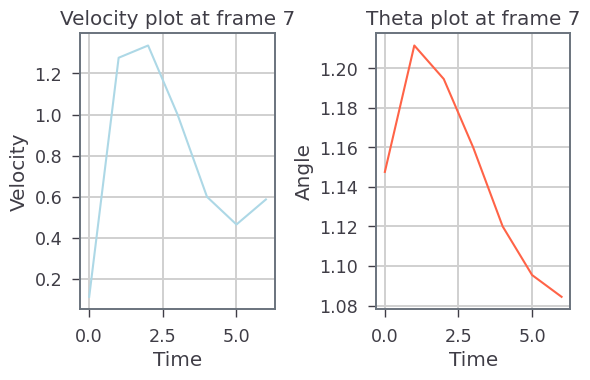

[8] loss: 0.582


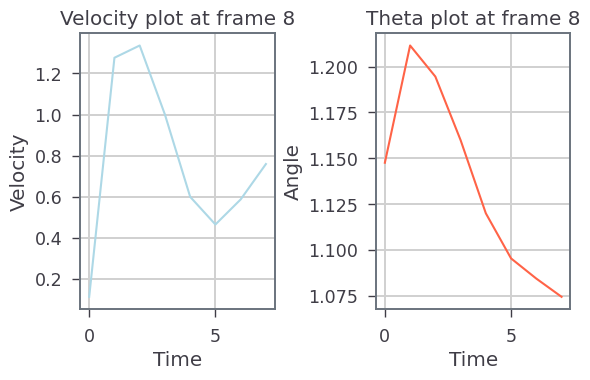

[9] loss: 0.493


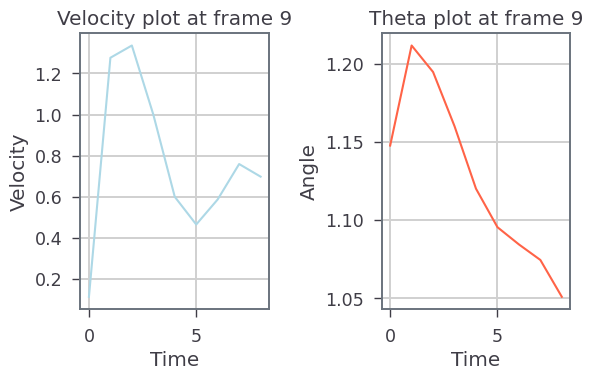

[10] loss: 0.406


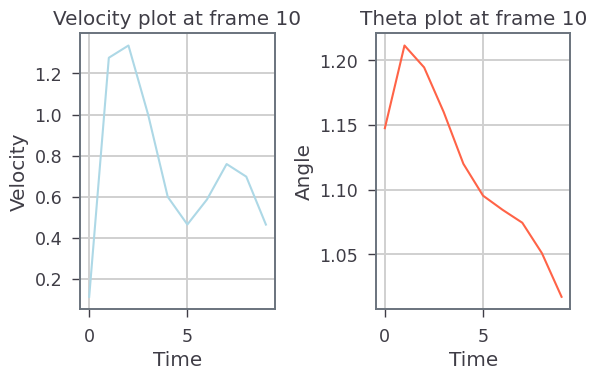

[11] loss: 0.357


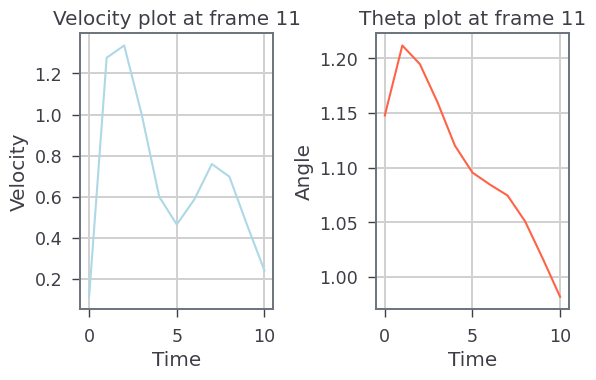

[12] loss: 0.314


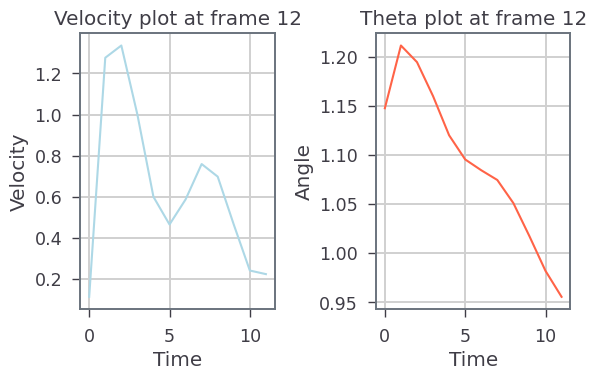

[13] loss: 0.289


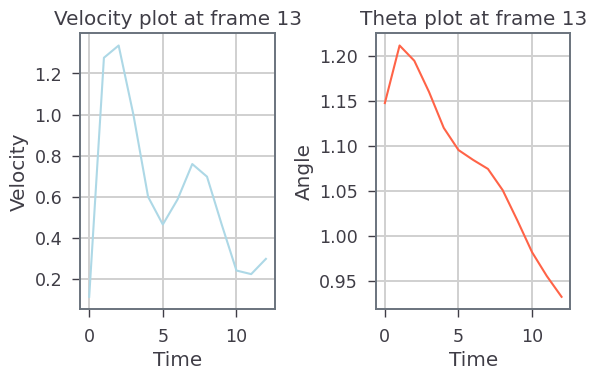

[14] loss: 0.272


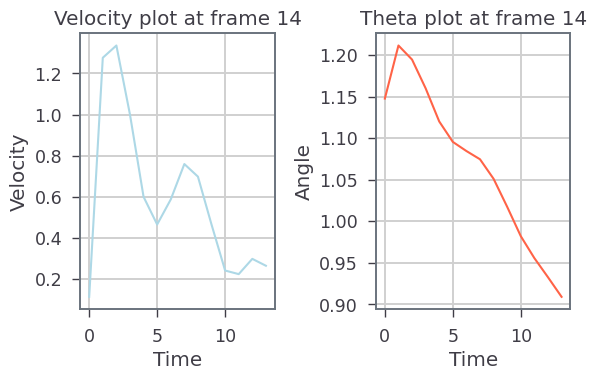

[15] loss: 0.247


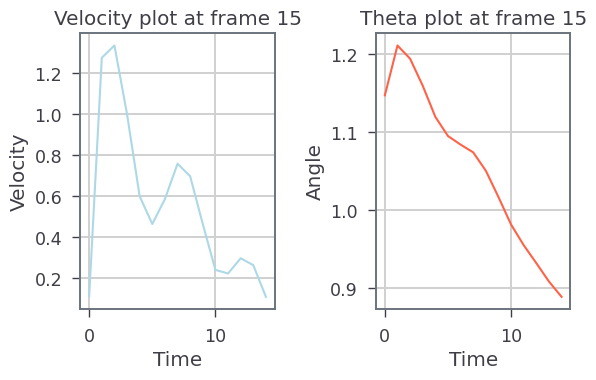

[16] loss: 0.233


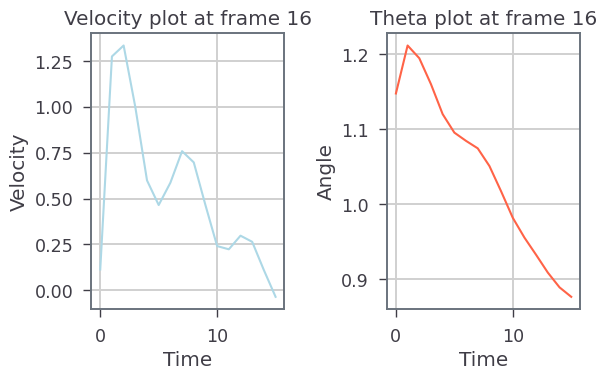

[17] loss: 0.216


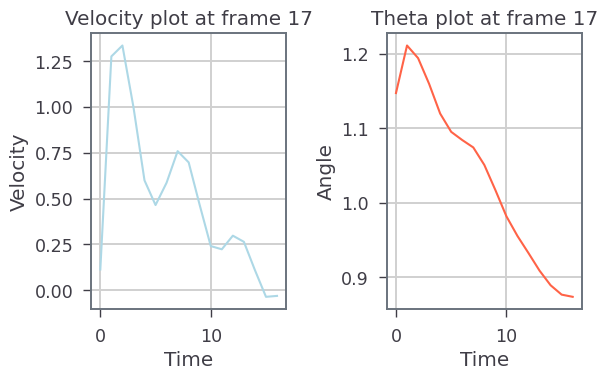

[18] loss: 0.204


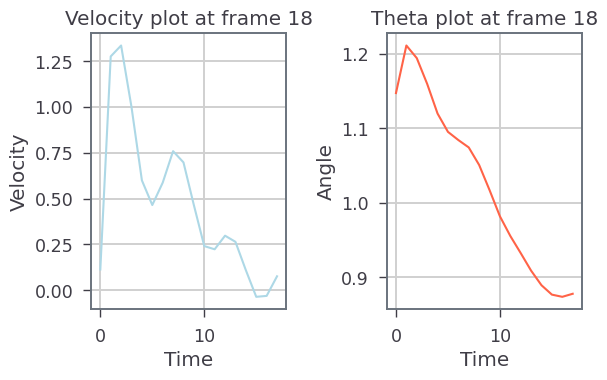

[19] loss: 0.201


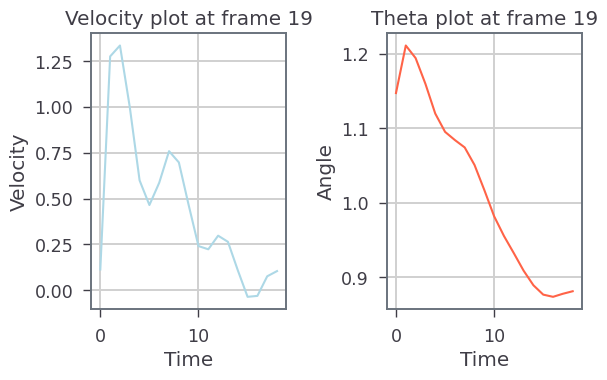

[20] loss: 0.194


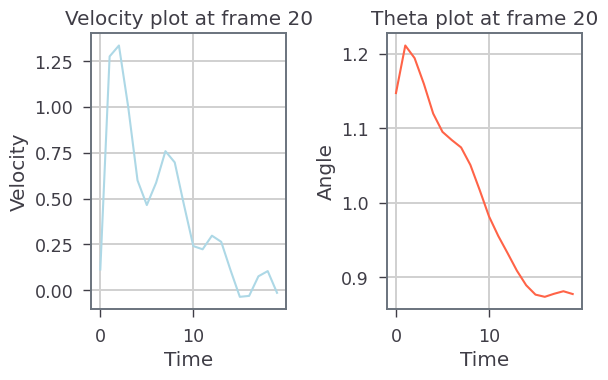

[21] loss: 0.196


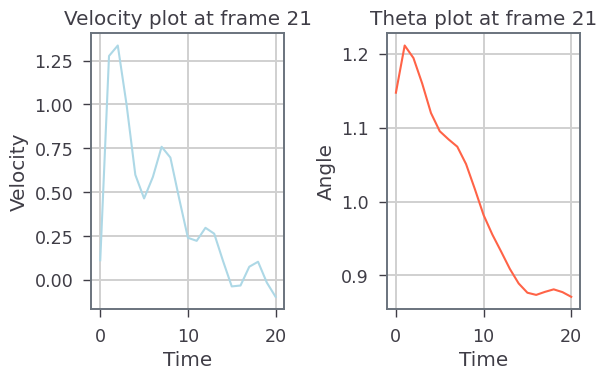

[22] loss: 0.188


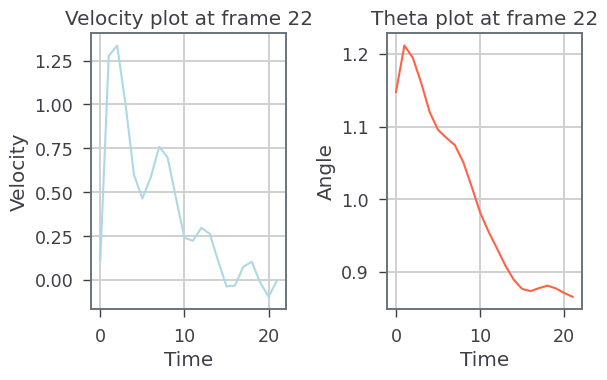

[23] loss: 0.185


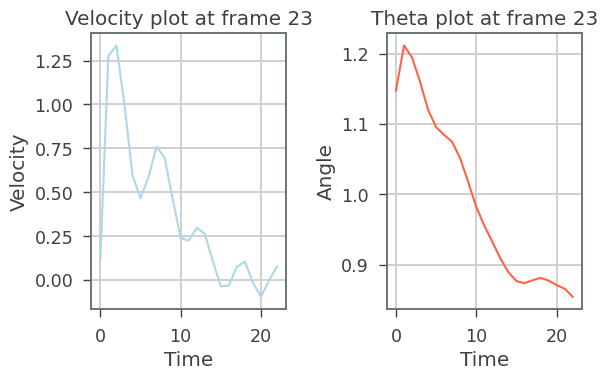

[24] loss: 0.174


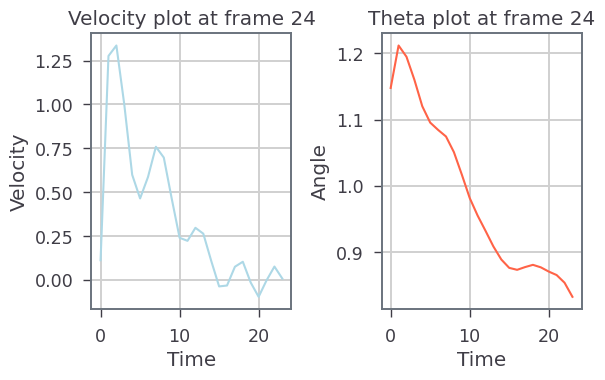

[25] loss: 0.167


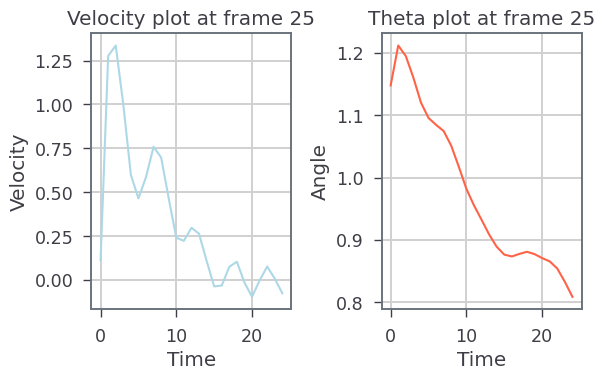

[26] loss: 0.159


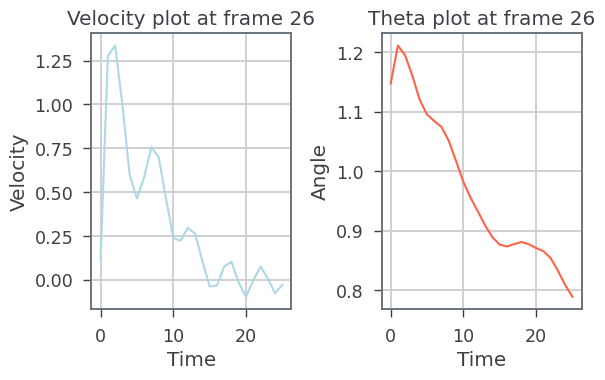

[27] loss: 0.155


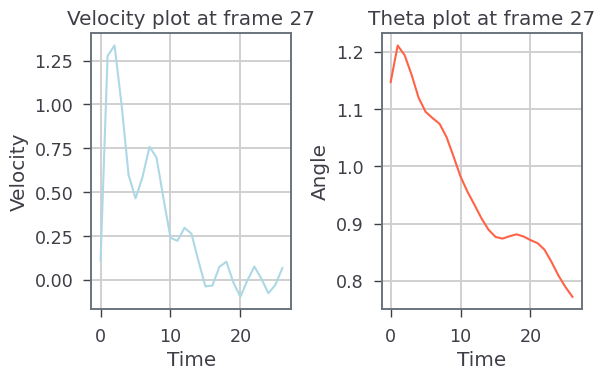

[28] loss: 0.150


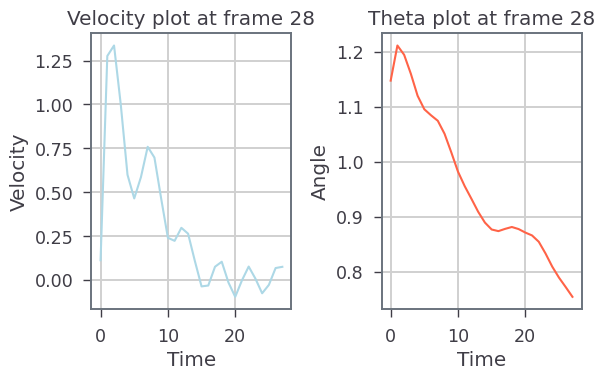

[29] loss: 0.147


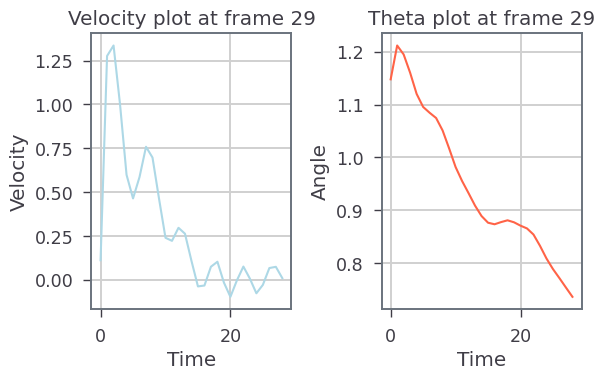

[30] loss: 0.146


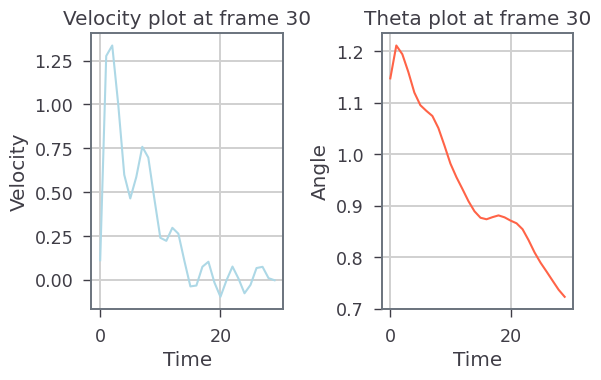

[31] loss: 0.143


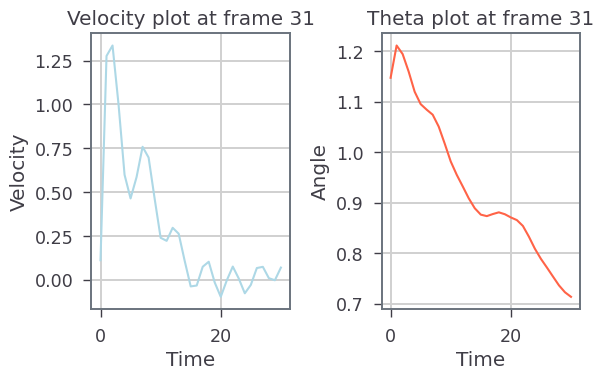

[32] loss: 0.142


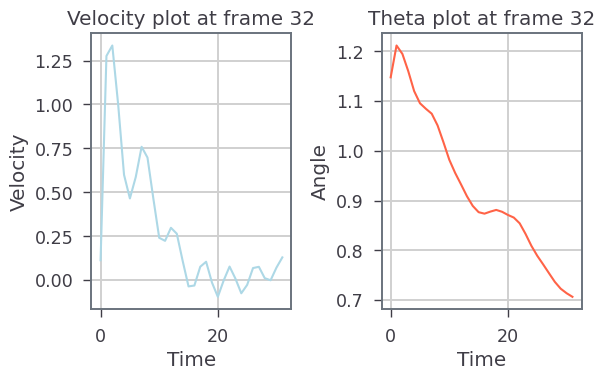

[33] loss: 0.139


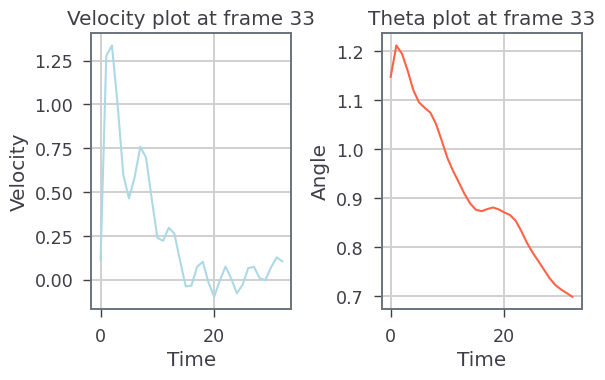

[34] loss: 0.137


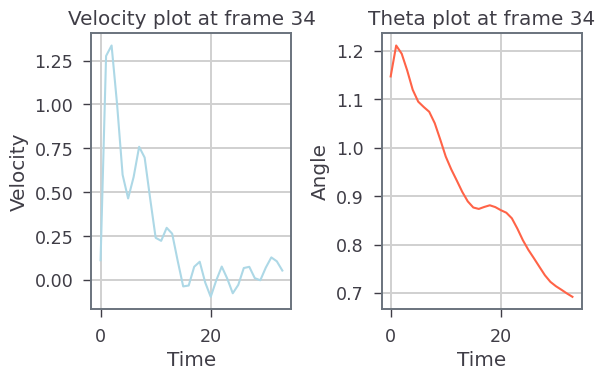

[35] loss: 0.134


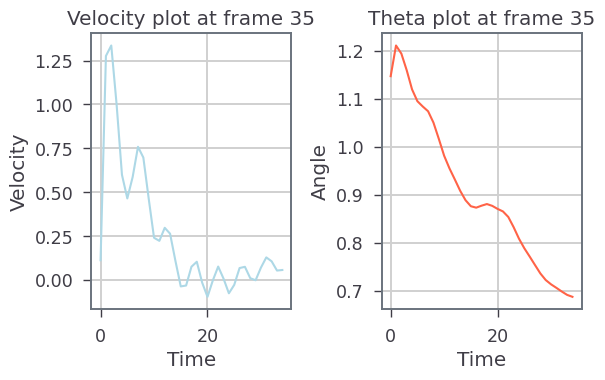

[36] loss: 0.130


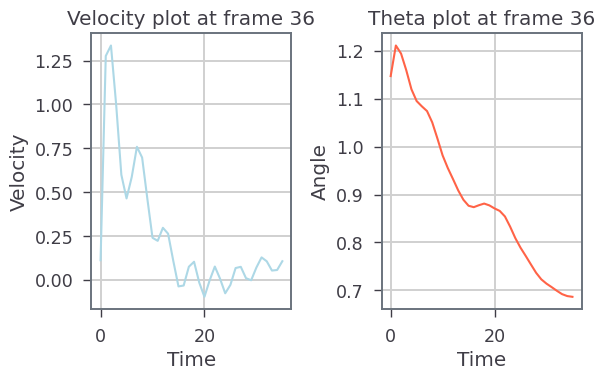

[37] loss: 0.127


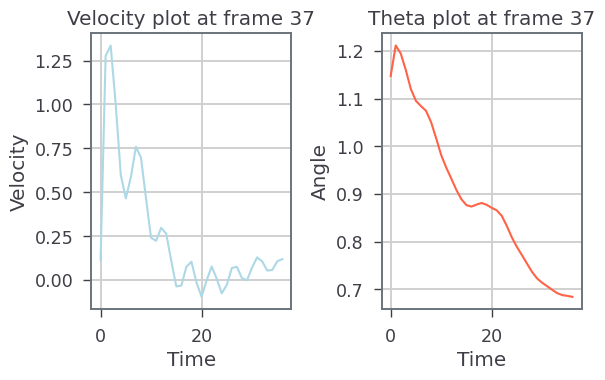

[38] loss: 0.124


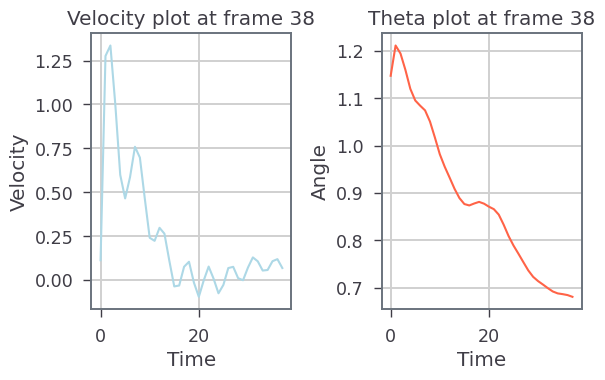

[39] loss: 0.121


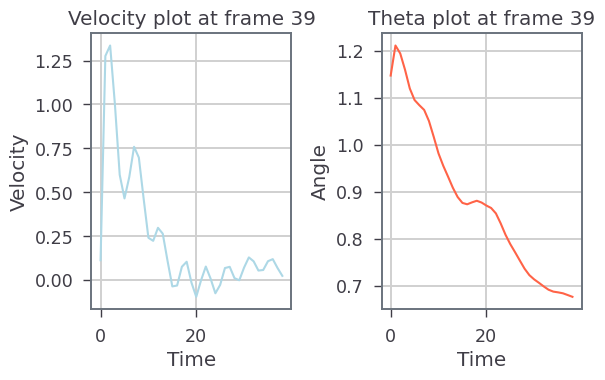

[40] loss: 0.118


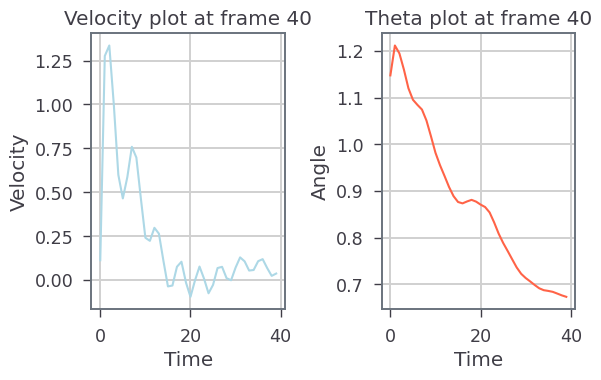

[41] loss: 0.115


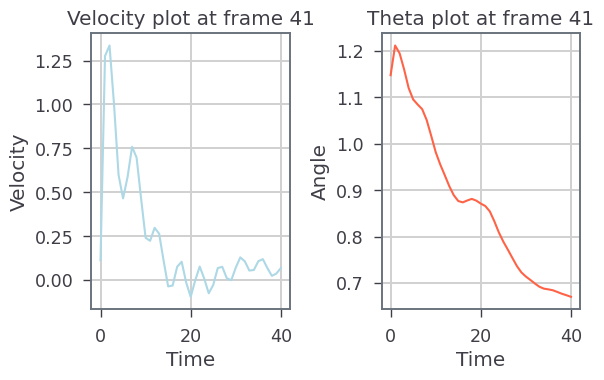

[42] loss: 0.113


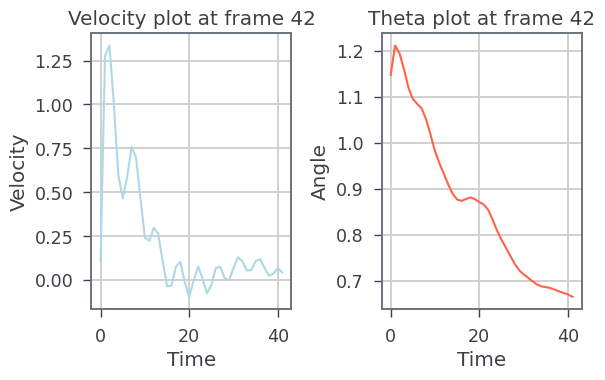

[43] loss: 0.110


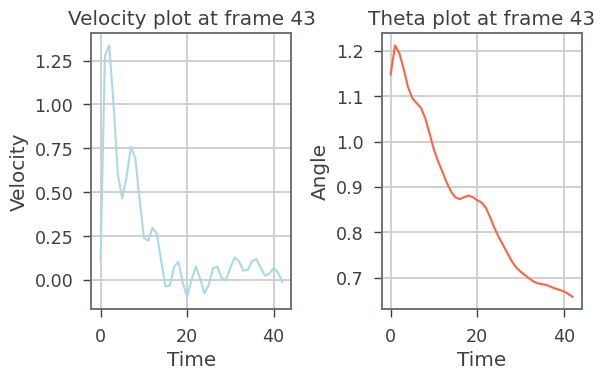

[44] loss: 0.108


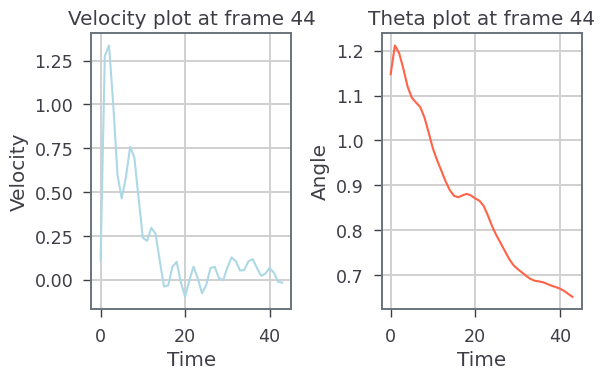

[45] loss: 0.106


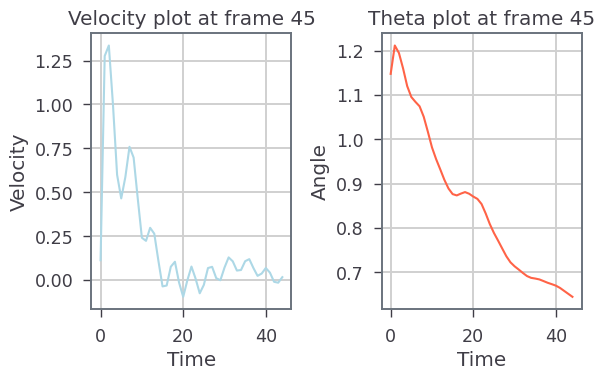

[46] loss: 0.103


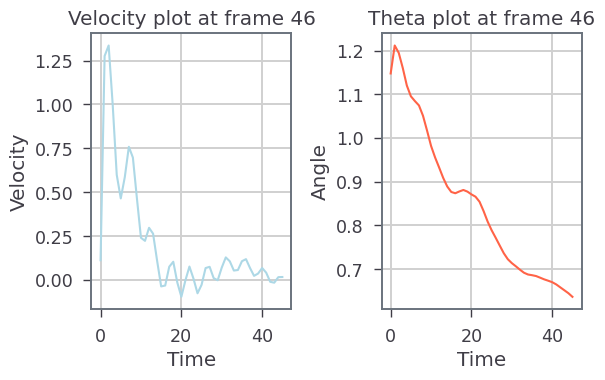

[47] loss: 0.101


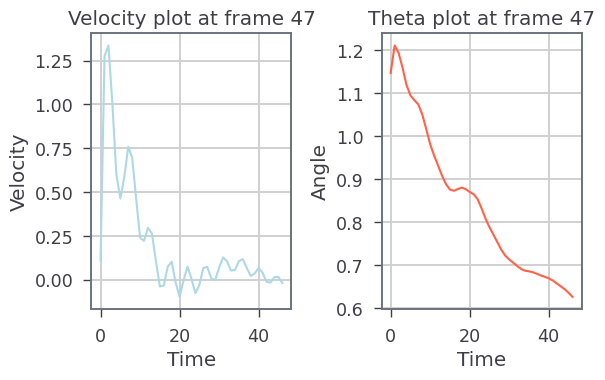

[48] loss: 0.098


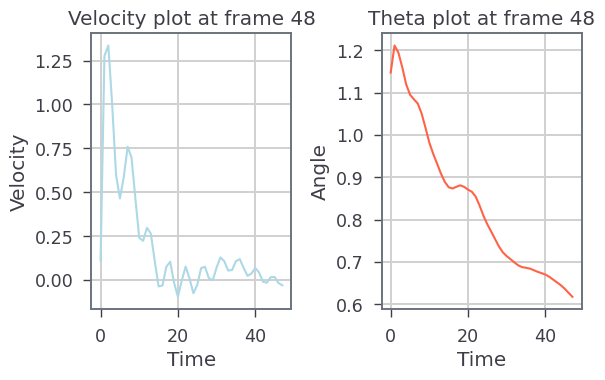

[49] loss: 0.096


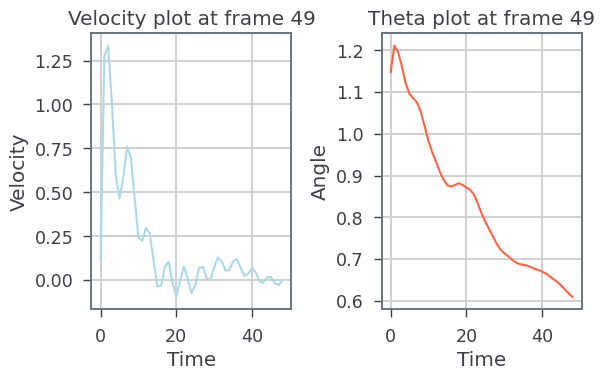

[50] loss: 0.093


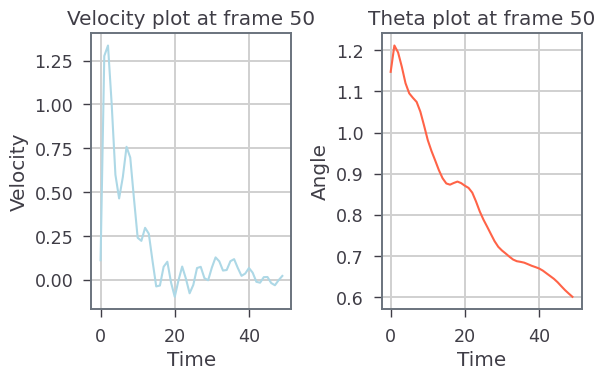

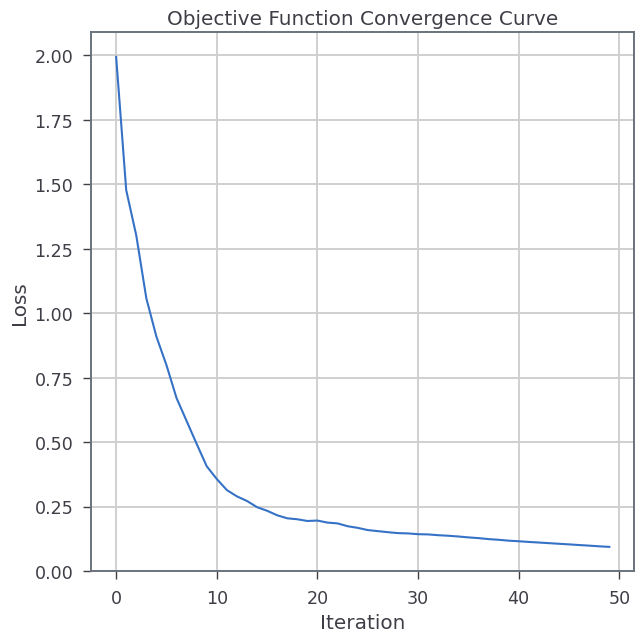

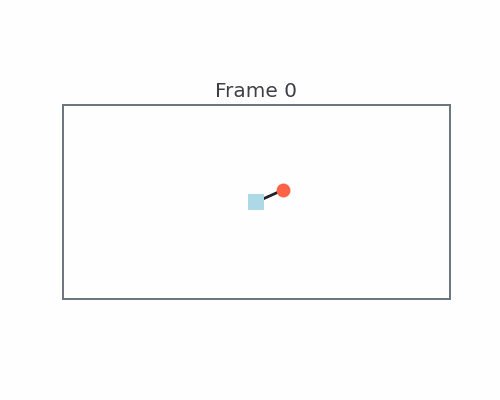

In [38]:
class Controller(nn.Module):
    def __init__(self):
        super(Controller, self).__init__()
        self.l1 = nn.Linear(4, 32)
        nn.init.xavier_uniform_(self.l1.weight)
        nn.init.zeros_(self.l1.bias)

        self.l2 = nn.Linear(32, 32)
        nn.init.xavier_uniform_(self.l2.weight)
        nn.init.zeros_(self.l2.bias)

        self.l3 = nn.Linear(32, 1)
        nn.init.xavier_uniform_(self.l3.weight)
        nn.init.zeros_(self.l3.bias)

    def forward(self, state):
        h = torch.relu(self.l1(state))
        h = torch.relu(self.l2(h))
        u = self.l3(h)
        return u

class Dynamics(nn.Module):
    def __init__(self, M, m, l, g=9.81):
        super(Dynamics, self).__init__()
        self.M = M
        self.m = m
        self.l = l
        self.g = g

    def forward(self, x, u):
        M, m, l, g = self.M, self.m, self.l, self.g
        s = torch.sin(x[2])
        c = torch.cos(x[2])

        dxdt = torch.zeros_like(x)
        dxdt[0] = x[1]
        dxdt[2] = x[3]

        den1 = M + m - m * c**2
        dxdt[1] = ((u + m * s * (l * x[3]**2 + g * c)) / den1)
        dxdt[3] = ((- l * m * s * x[3]**2 - s * u - (M + m) * g * s) / (l * den1))

        return x + dxdt * 0.01

class Simulation(nn.Module):
    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T

    def forward(self, x0):
        x = x0
        for _ in range(self.T):
            u = self.controller(x)
            x = self.dynamics(x, u)
        return x

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.controller = simulation.controller
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.controller.parameters(), lr=0.01)

        # Lists for visualization
        self.losses = []
        self.velocities = []
        self.angles = []

    def train(self, target):
        for i in range(50):
            self.optimizer.zero_grad()
            xT = self.simulation(torch.tensor([0., 0., 1., 0.]))

            # Store velocities and angles for visualization
            self.velocities.append(xT[1].item())
            self.angles.append(xT[2].item())

            loss = self.loss_fn(xT, target)
            self.losses.append(loss.item())  # Store the loss for visualization
            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.controller.parameters(), 1.0)
            self.optimizer.step()
            print(f"[{i+1}] loss: {loss.item():.3f}")

            # Plot the full velocities and angles after each training iteration
            self.plot_velocities_and_angles(i)

    def plot_velocities_and_angles(self,i):
        plt.figure(figsize=(6, 4))

        # Plotting velocity vs time
        plt.subplot(1, 2, 1)
        plt.plot(self.velocities, label='Velocity', color='lightblue')
        plt.xlabel('Time')
        plt.ylabel('Velocity')
        plt.title(f'Velocity plot at frame {i+1}')
        plt.grid(True)

        # Plotting angle vs time
        plt.subplot(1, 2, 2)
        plt.plot(self.angles, label='Angle', color='tomato')
        plt.xlabel('Time')
        plt.ylabel('Angle')
        plt.title(f'Theta plot at frame {i+1}')
        plt.grid(True)

        plt.tight_layout()
        plt.pause(0.1)

        plt.show()

    def visualize_results(self):
        # Plotting Loss vs. Iteration
        plt.figure(figsize=(7, 7))
        plt.plot(self.losses)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Objective Function Convergence Curve')
        plt.grid(True)
        plt.show()

def draw_cart_pendulum(t, angles, velocities, ax=None):
    l = 0.3

    cart_x = velocities[t] * t * 0.01
    theta = angles[t]

    pendulum_x = cart_x + l * np.sin(theta)
    pendulum_y = l * np.cos(theta)

    if not ax:
        fig, ax = plt.subplots(figsize=(5, 4))

    ax.clear()
    ax.plot([cart_x, pendulum_x], [0, pendulum_y], color="k", lw=2)
    ax.plot(cart_x, 0, 's', color='lightblue', markersize=12)
    ax.plot(pendulum_x, pendulum_y, 'o', color='tomato', markersize=10)

    # Setting limits, aspect ratio, and title
    ax.set_xlim(-2, 2)
    ax.set_ylim(-1, 1)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True)
    ax.set_title(f"Frame {t}")
    return ax

controller = Controller()
dynamics = Dynamics(M=0.5, m=0.2, l=0.3)
simulation = Simulation(controller, dynamics, T=100)
training = Optimize(simulation)

x_target = torch.tensor([0., 0., 0., 0.])
training.train(x_target)
training.visualize_results()

fig, ax = plt.subplots(figsize=(5, 4))
ani = FuncAnimation(fig, draw_cart_pendulum, frames=len(training.angles), fargs=(training.angles, training.velocities, ax), repeat=True)

# Save as a gif
writer = PillowWriter(fps=20)
ani.save("inverted_pendulum_animation.gif", writer=writer)
plt.close(fig)

display(Image(filename="inverted_pendulum_animation.gif"))


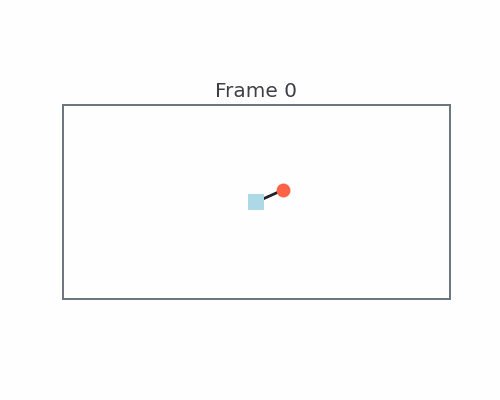